In [24]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as sk

## Load data

In [2]:
df_train = pd.read_csv('data/sales_train.csv')
df_test = pd.read_csv('data/test.csv')
df_sample = pd.read_csv('data/sample_submission.csv')
df_shops = pd.read_csv('data/shops.csv')
df_items = pd.read_csv('data/items.csv')
df_item_categories = pd.read_csv('data/item_categories.csv')

In [3]:
print('Train sample\n', df_train.head(10))
print('Test sample\n', df_test.head(10))
print('Sample submission\n', df_sample.head(10))
print('Shops\n', df_shops.head(10))
print('Items\n', df_items.head(10))
print('Item categories\n', df_item_categories.head(10))

Train sample
          date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
5  10.01.2013               0       25     2564      349.00           1.0
6  02.01.2013               0       25     2565      549.00           1.0
7  04.01.2013               0       25     2572      239.00           1.0
8  11.01.2013               0       25     2572      299.00           1.0
9  03.01.2013               0       25     2573      299.00           3.0
Test sample
    ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
5   5        5 

## Outlier removal

In [4]:
df_train[df_train['item_cnt_day'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.0,-1.0
2934462,18.10.2015,33,25,4896,6398.0,-1.0
2935263,05.10.2015,33,25,10039,249.0,-1.0
2935643,16.10.2015,33,25,7893,2990.0,-1.0


In [5]:
df_train.loc[df_train['item_cnt_day'] < 0, 'item_cnt_day'] = df_train['item_cnt_day'].mean().round()

In [6]:
print('Train sample\n', df_train.head(10))

Train sample
          date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00           1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
5  10.01.2013               0       25     2564      349.00           1.0
6  02.01.2013               0       25     2565      549.00           1.0
7  04.01.2013               0       25     2572      239.00           1.0
8  11.01.2013               0       25     2572      299.00           1.0
9  03.01.2013               0       25     2573      299.00           3.0


In [7]:
df_train.loc[df_train['item_price'] < 0, 'item_price'] = df_train['item_price'].mean()

In [8]:
df_train[df_train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [9]:
df_train[df_train.isna().any(1)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


Sort data by date, but first convert it to datetime to make up for a fact that it's in european format

In [10]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train.sort_values('date')
print(df_train.head(70000))

             date  date_block_num  shop_id  item_id  item_price  item_cnt_day
109593 2013-01-01               0       46    18616       349.0           1.0
85162  2013-01-01               0       54    11854       199.0           1.0
18128  2013-01-01               0       28     4906      1799.0           1.0
112216 2013-01-01               0       42     2931        99.0           1.0
85141  2013-01-01               0       54    11604       349.0           1.0
...           ...             ...      ...      ...         ...           ...
67575  2013-01-22               0       32    10783       249.0           1.0
41742  2013-01-22               0        1    13071       242.0           1.0
82385  2013-01-22               0       54     3470       349.0           1.0
51226  2013-01-22               0       16    12184       539.0           1.0
51315  2013-01-22               0       16    12293       549.0           1.0

[70000 rows x 6 columns]


In [11]:
#Reset indexes
df_train = df_train.reset_index(drop=True)
df_train.to_csv('data/sales_train_sorted.csv')
print(df_train.head(70000))

            date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0     2013-01-01               0       46    18616       349.0           1.0
1     2013-01-01               0       54    11854       199.0           1.0
2     2013-01-01               0       28     4906      1799.0           1.0
3     2013-01-01               0       42     2931        99.0           1.0
4     2013-01-01               0       54    11604       349.0           1.0
...          ...             ...      ...      ...         ...           ...
69995 2013-01-22               0       32    10783       249.0           1.0
69996 2013-01-22               0        1    13071       242.0           1.0
69997 2013-01-22               0       54     3470       349.0           1.0
69998 2013-01-22               0       16    12184       539.0           1.0
69999 2013-01-22               0       16    12293       549.0           1.0

[70000 rows x 6 columns]


## Exploratory data analysis
Form a dataframe with date, revenue and sale count per day

In [13]:
date = None
sale_cnt = None
price = None
df = pd.DataFrame(columns = ['date', 'revenue', 'item_cnt_day'])
for index, row in df_train.iterrows():
    if index == 0:
        date = row.at['date']
        sale_cnt = row.at['item_cnt_day']
        price = row.at['item_price']
    elif row.at['date'] == date:
        sale_cnt += row.at['item_cnt_day']
        price += row.at['item_price']
    else:
        df_row = pd.DataFrame({'date' : [date], 'revenue' : [sale_cnt*price], 'item_cnt_day' : [sale_cnt]})
        df = df.append(df_row)
        date = row.at['date']
        sale_cnt = row.at['item_cnt_day']
        price = row.at['item_price']
    #Check for last row
    if index == len(df_train) - 1:
        df_row = pd.DataFrame({'date' : [date], 'revenue' : [sale_cnt*price], 'item_cnt_day' : [sale_cnt]})
        df = df.append(df_row)
        

In [14]:
df = df.reset_index(drop=True)
df.to_csv('data/sales_train_summed.csv')
print(df.head(30))

         date       revenue  item_cnt_day
0  2013-01-01  2.378721e+09        1963.0
1  2013-01-02  8.625351e+09        3839.0
2  2013-01-03  9.001836e+09        3862.0
3  2013-01-04  4.288860e+09        2590.0
4  2013-01-05  1.210480e+10        4883.0
5  2013-01-06  1.641674e+10        5746.0
6  2013-01-07  6.880716e+09        3420.0
7  2013-01-08  5.689272e+09        3230.0
8  2013-01-09  1.444169e+10        5453.0
9  2013-01-10  5.352745e+09        2957.0
10 2013-01-11  1.252864e+10        4447.0
11 2013-01-12  1.874267e+10        5008.0
12 2013-01-13  1.271759e+10        4513.0
13 2013-01-14  4.833907e+09        2619.0
14 2013-01-15  6.558227e+09        3169.0
15 2013-01-16  6.251588e+09        3045.0
16 2013-01-17  6.323351e+09        3102.0
17 2013-01-18  9.209700e+09        3711.0
18 2013-01-19  2.219381e+10        6050.0
19 2013-01-20  1.599115e+10        5132.0
20 2013-01-21  4.792627e+09        2658.0
21 2013-01-22  4.917777e+09        2785.0
22 2013-01-23  4.712597e+09       

### Plotting

### Plots for the span of 36 months:

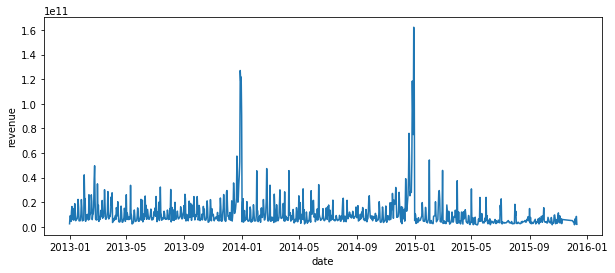

In [28]:
plt.figure(figsize=(10,4))
sb.lineplot(x = 'date', y = 'revenue', data = df)

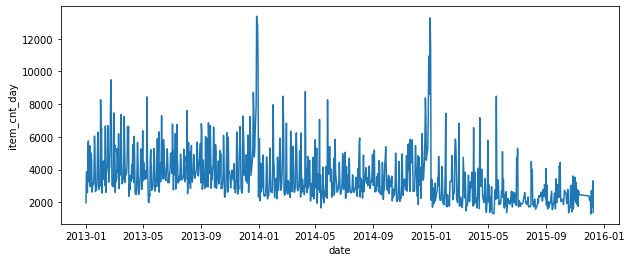

In [30]:
plt.figure(figsize=(10,4))
sb.lineplot(x = 'date', y = 'item_cnt_day', data = df)

We can definitely see that there are some spikes both in revenue and in number of sales. These are most likely due to Christmas season.

### Plots for the span of one month:

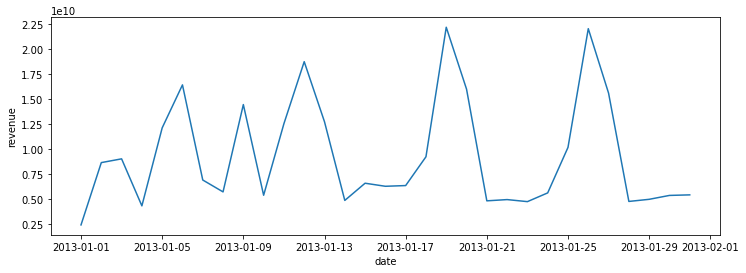

In [39]:
plt.figure(figsize=(12,4))
sb.lineplot(x = 'date', y = 'revenue', data = df[:31])

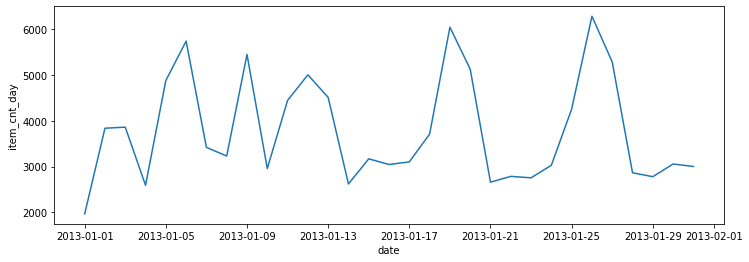

In [38]:
plt.figure(figsize=(12,4))
sb.lineplot(x = 'date', y = 'item_cnt_day', data = df[:31])

Spikes above are probably due to the fact that most people go shopping on weekends.

## Data preprocessing